# Modeling

In [70]:
#import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# load clean dataset and inspect

data = pd.read_csv('data/diabetes_data_clean.csv', index_col=0)

data.head()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,diag_3_respiratory,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_No,insulin_Steady,insulin_Up
1,149190,55629189,3,59,0,18,0,0,0,9,...,0,0,1,0,0,1,0,0,0,1
2,64410,86047875,2,11,5,13,2,0,1,6,...,0,0,1,0,0,1,0,1,0,0
3,500364,82442376,2,44,1,16,0,0,0,7,...,0,0,1,0,0,1,0,0,0,1
4,16680,42519267,1,51,0,8,0,0,0,5,...,0,0,1,0,0,1,0,0,1,0
5,35754,82637451,3,31,6,16,0,0,0,9,...,0,0,1,0,0,1,0,0,1,0


In [73]:
# set variables for model
y = data['readmitted']
X = data.drop(columns=['encounter_id', 'patient_nbr', 'readmitted'])

In [74]:
# perform train test split on data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

## Create Functions for Modeling and Visualizations

In [151]:
def get_scores(y_test, y_hat_test):
    scores_dict = {'precision':round(precision_score(y_test, y_hat_test),2),
           'recall': round(recall_score(y_test, y_hat_test),2),
           'accuracy': round(accuracy_score(y_test, y_hat_test),2),
           'f1': round(f1_score(y_test, y_hat_test),2)}
    return scores_dict

In [ ]:
def run_model(model):
    
    # fit model
    model.fit(X_train, y_train)
    
    # make predictions
    y_hat_train = logreg.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    # print classification report
    print(classification_report(y_test, y_hat_test))
    
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Confusion Matrix - Decision Tree')
    disp = plot_confusion_matrix(dtree_baseline, X_test, y_test, ax = ax)
    plt.grid(False)
    
    
    return get_scores(y_test, y_hat_test)

In [ ]:
def plot_roc(model):
    y_score = model.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
def plot_top_10_features(model):
    feature_names = X_train.columns
    feature_imports = model.feature_importances_
    most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], 
                                     columns=["Feature", "Importance"]).nlargest(10, "Importance")
    most_imp_features.sort_values(by="Importance", inplace=True)
    print(most_imp_features)
    plt.figure(figsize=(10,6))
    plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
    plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
    plt.xlabel('Importance')
    plt.title('Most important features - Decision Tree')
    plt.show()

## Logistic Regression Model

We will start with a simple logistic regression model using scikit learn. For the baseline model, we will set the solver parameter to 'liblinear' and a C value of 1e12, and use the defaults for all other parameters.

### Baseline Logistic Regression

In [152]:
# import necessary libraries

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [153]:
# instantiate LogisticRegression()

logreg = LogisticRegression(C=1e12, solver='liblinear')

              precision    recall  f1-score   support

           0       0.61      0.78      0.68     12972
           1       0.64      0.45      0.53     11541

    accuracy                           0.62     24513
   macro avg       0.63      0.61      0.61     24513
weighted avg       0.63      0.62      0.61     24513



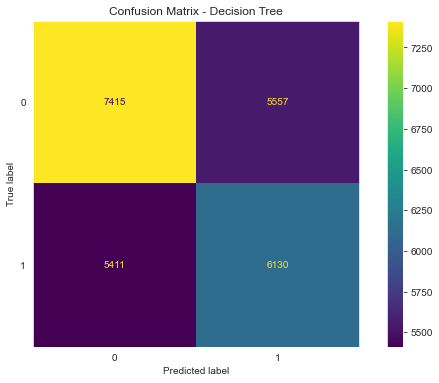

In [154]:
# Use run_model function to fit the model, make predictions, 
# print classification report, plot confusion matrix,
# and store evaluation metrics

log_scores = run_model(logreg)

In [155]:
log_scores

{'precision': 0.64, 'recall': 0.45, 'accuracy': 0.62, 'f1': 0.53}

### Logistic Regression - Balanced Class Weight

Based on the above confusion matrix, it appears more of the true readmissions are being classified as not readmissions. We suspect this has something to do with unequal class weights. Let's see if passing a class_weight parameter of 'balanced' helps our results.

In [158]:
# confirm class weights are unequal
data.readmitted.value_counts()

0    52337
1    45715
Name: readmitted, dtype: int64

In [159]:
logreg_balance = LogisticRegression(C= 1e12, solver='liblinear',
                              class_weight='balanced')

              precision    recall  f1-score   support

           0       0.64      0.69      0.66     12972
           1       0.61      0.56      0.59     11541

    accuracy                           0.63     24513
   macro avg       0.63      0.62      0.62     24513
weighted avg       0.63      0.63      0.63     24513



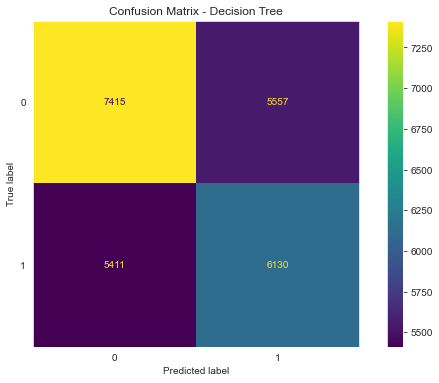

In [162]:
logreg_balance_scores = run_model(logreg_balance)

Our recall, accuracy and f1 score all improved; since our recall score is most important to us, we are going to store the scores from this model as our logistic regression scores.

In [174]:
logreg_balance_scores

{'precision': 0.61, 'recall': 0.56, 'accuracy': 0.63, 'f1': 0.59}

In [163]:
logreg_scores = logreg_balance_scores

In [123]:
# def get_scores(y_test, y_hat_test):
#     model = run_log_reg
#     precision = round(precision_score(y_test, y_hat_test),2)
#     recall = round(recall_score(y_test, y_hat_test),2)
#     accuracy = round(accuracy_score(y_test, y_hat_test),2)
#     f1 = round(f1_score(y_test, y_hat_test),2)
    
#     return precision, recall, accuracy, f1

Let's also plot our ROC function to get a sense for our true positive rate vs. false positive rate.

AUC: 0.6699574587783308


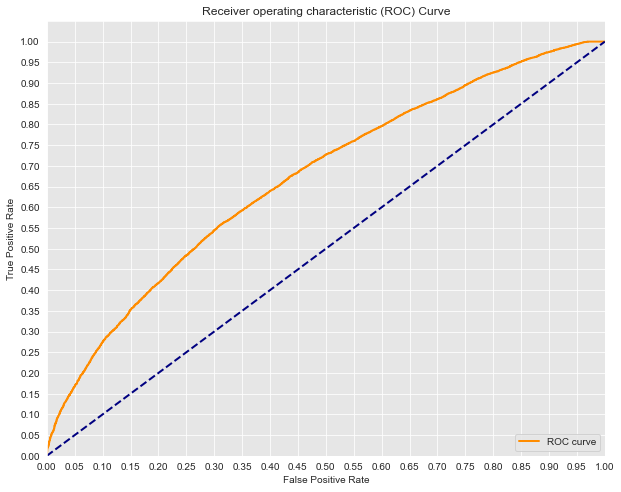

In [165]:
from sklearn.metrics import roc_curve, auc

plot_roc(logreg_balance)

* Add analysis of ROC curve

Let's try using a different classification model and see if we can improve our results.

## K-Nearest Neighbors

### K-Nearest Neighbors Baseline

In [166]:
# # Import StandardScaler
# from sklearn.preprocessing import StandardScaler

# # Import KNeighborsClassifier
# from sklearn.neighbors import KNeighborsClassifier

# # Instantiate StandardScaler
# scaler = StandardScaler()


In [167]:
# def run_knn(X_train, X_test, y_train, y_test):
#     scaler = StandardScaler()
#     scaled_data_train = scaler.fit_transform(X_train)
#     scaled_data_test = scaler.transform(X_test)
#     clf = KNeighborsClassifier()
#     clf.fit(scaled_data_train, y_train)
#     y_hat_test = clf.predict(scaled_data_test)
    
#     fig, ax = plt.subplots(figsize=(10, 6))
#     ax.set_title('Confusion Matrix - K-Nearest Neighbors')
#     disp = plot_confusion_matrix(clf, scaled_data_test, y_test, ax = ax)
#     plt.grid(False)
#     print(classification_report(y_test, y_hat_test))
#     print('Testing Precision: ', precision_score(y_test, y_hat_test))
#     print('Testing Recall: ', recall_score(y_test, y_hat_test))
#     print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
#     print('Testing F1-Score: ', f1_score(y_test, y_hat_test))
    
#     return clf

In [168]:
# run_knn(X_train, X_test, y_train, y_test)

In [169]:
# # Instantiate KNeighborsClassifier
# clf = KNeighborsClassifier()

# # Fit the classifier
# clf.fit(scaled_data_train, y_train)

# # Predict on the test set
# y_hat_test = clf.predict(scaled_data_test)

In [170]:
# print(classification_report(y_test, y_hat_test))
# print('Testing Precision: ', precision_score(y_test, y_hat_test, average='weighted'))
# print('Testing Recall: ', recall_score(y_test, y_hat_test, average='weighted'))
# print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
# print('Testing F1-Score: ', f1_score(y_test, y_hat_test, average='weighted'))

## Decision Trees

Next, we are going to see if we can obtain better test results using decision trees. Decision trees classify categorical data by partitioning the data into sets of similar datapoints.

We had attempted using a K-Nearest Neighbors classifier, but given our dataset has nearly 100k rows, using this classifier was not practical from a runtime or memory standpoint. 

### Baseline Decision Tree

              precision    recall  f1-score   support

           0       0.58      0.58      0.58     12972
           1       0.53      0.53      0.53     11541

    accuracy                           0.55     24513
   macro avg       0.55      0.55      0.55     24513
weighted avg       0.55      0.55      0.55     24513



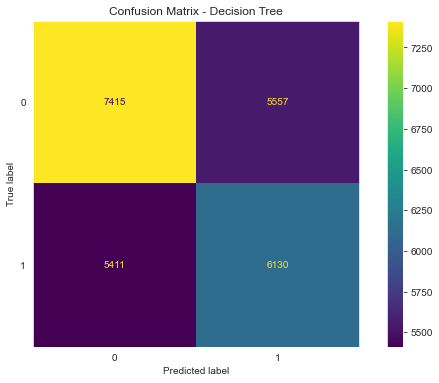

In [171]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_baseline = DecisionTreeClassifier()
tree_scores = run_model(tree_baseline)

In [173]:
tree_scores

{'precision': 0.53, 'recall': 0.53, 'accuracy': 0.55, 'f1': 0.53}

Our scores did not improve from our logistic regression model, however, we should be able to improve these results by tuning our model.

### Improved Decision Tree Using GridSearchCV

Next, we are going to use GridSearchCV to figure out the optimal parameters for the decision tree model. See below for a quick description of what each of these parameters mean:

* criterion: methodology used to calculate information gain
* max_depth: restrict the depth of the tree to be more generalized
* min_samples_split: the minimum number of samples required to split an internal node
* max_features: the maximum number of features to consider when looking at a split
* min_samples_leaf: the minimum number of samples required to be at a leaf node 

In [185]:
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,5,10],
    'min_samples_split': [5,10,20],
    'min_samples_leaf': [0.1, 0.3, 0.5]
}

grid_tree = GridSearchCV(clf, param_grid, cv=3)
grid_tree.fit(X_train, y_train)

grid_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

              precision    recall  f1-score   support

           0       0.61      0.74      0.67     12972
           1       0.62      0.47      0.54     11541

    accuracy                           0.62     24513
   macro avg       0.62      0.61      0.60     24513
weighted avg       0.62      0.62      0.61     24513



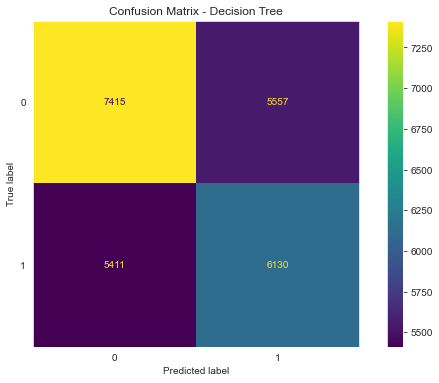

In [186]:
new_tree = DecisionTreeClassifier(criterion = grid_tree.best_params_['criterion'], 
                                   max_depth = grid_tree.best_params_['max_depth'], 
                                   min_samples_split = grid_tree.best_params_['min_samples_split'],
                                   min_samples_leaf = grid_tree.best_params_['min_samples_leaf'])
new_tree_scores = run_model(new_tree)

Although our precision, accuracy and f1 scores increased, our recall actually decreased, which is the metric we are most interested in improving. Even though we are more concerned about recall, it is likely to be more useful to have a more generalized tree, so we are going to proceed with this version of the model.

In [187]:
tree_scores = new_tree_scores

In [188]:
# def plot_feature_importances(model):
#     n_features = X_train.shape[1]
#     plt.figure(figsize=(8,16))
#     plt.barh(range(n_features), model.feature_importances_, align='center') 
#     plt.yticks(np.arange(n_features), X_train.columns.values) 
#     plt.xlabel('Feature importance')
#     plt.ylabel('Feature')

# plot_feature_importances(best_tree)

                              Feature  Importance
1                  num_lab_procedures    0.005618
3                     num_medications    0.010338
4                   number_outpatient    0.015124
28  discharge_disposition_id_transfer    0.028310
16                        diabetesMed    0.030950
26      discharge_disposition_id_home    0.045144
29   discharge_disposition_id_unknown    0.059238
5                    number_emergency    0.069283
7                    number_diagnoses    0.077693
6                    number_inpatient    0.646507


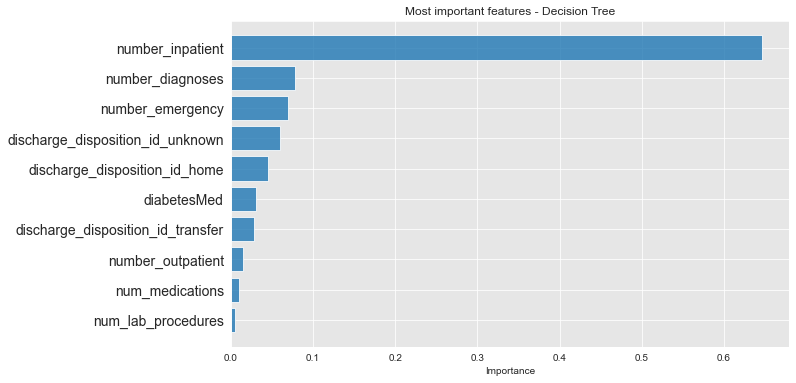

In [189]:
plot_top_10_features(new_tree)

In this model, our most important features are the number of inpatient visits, diagnoses and emergency visits as well as the discharge disposition ids. Let's also look at the structure of our actual tree.

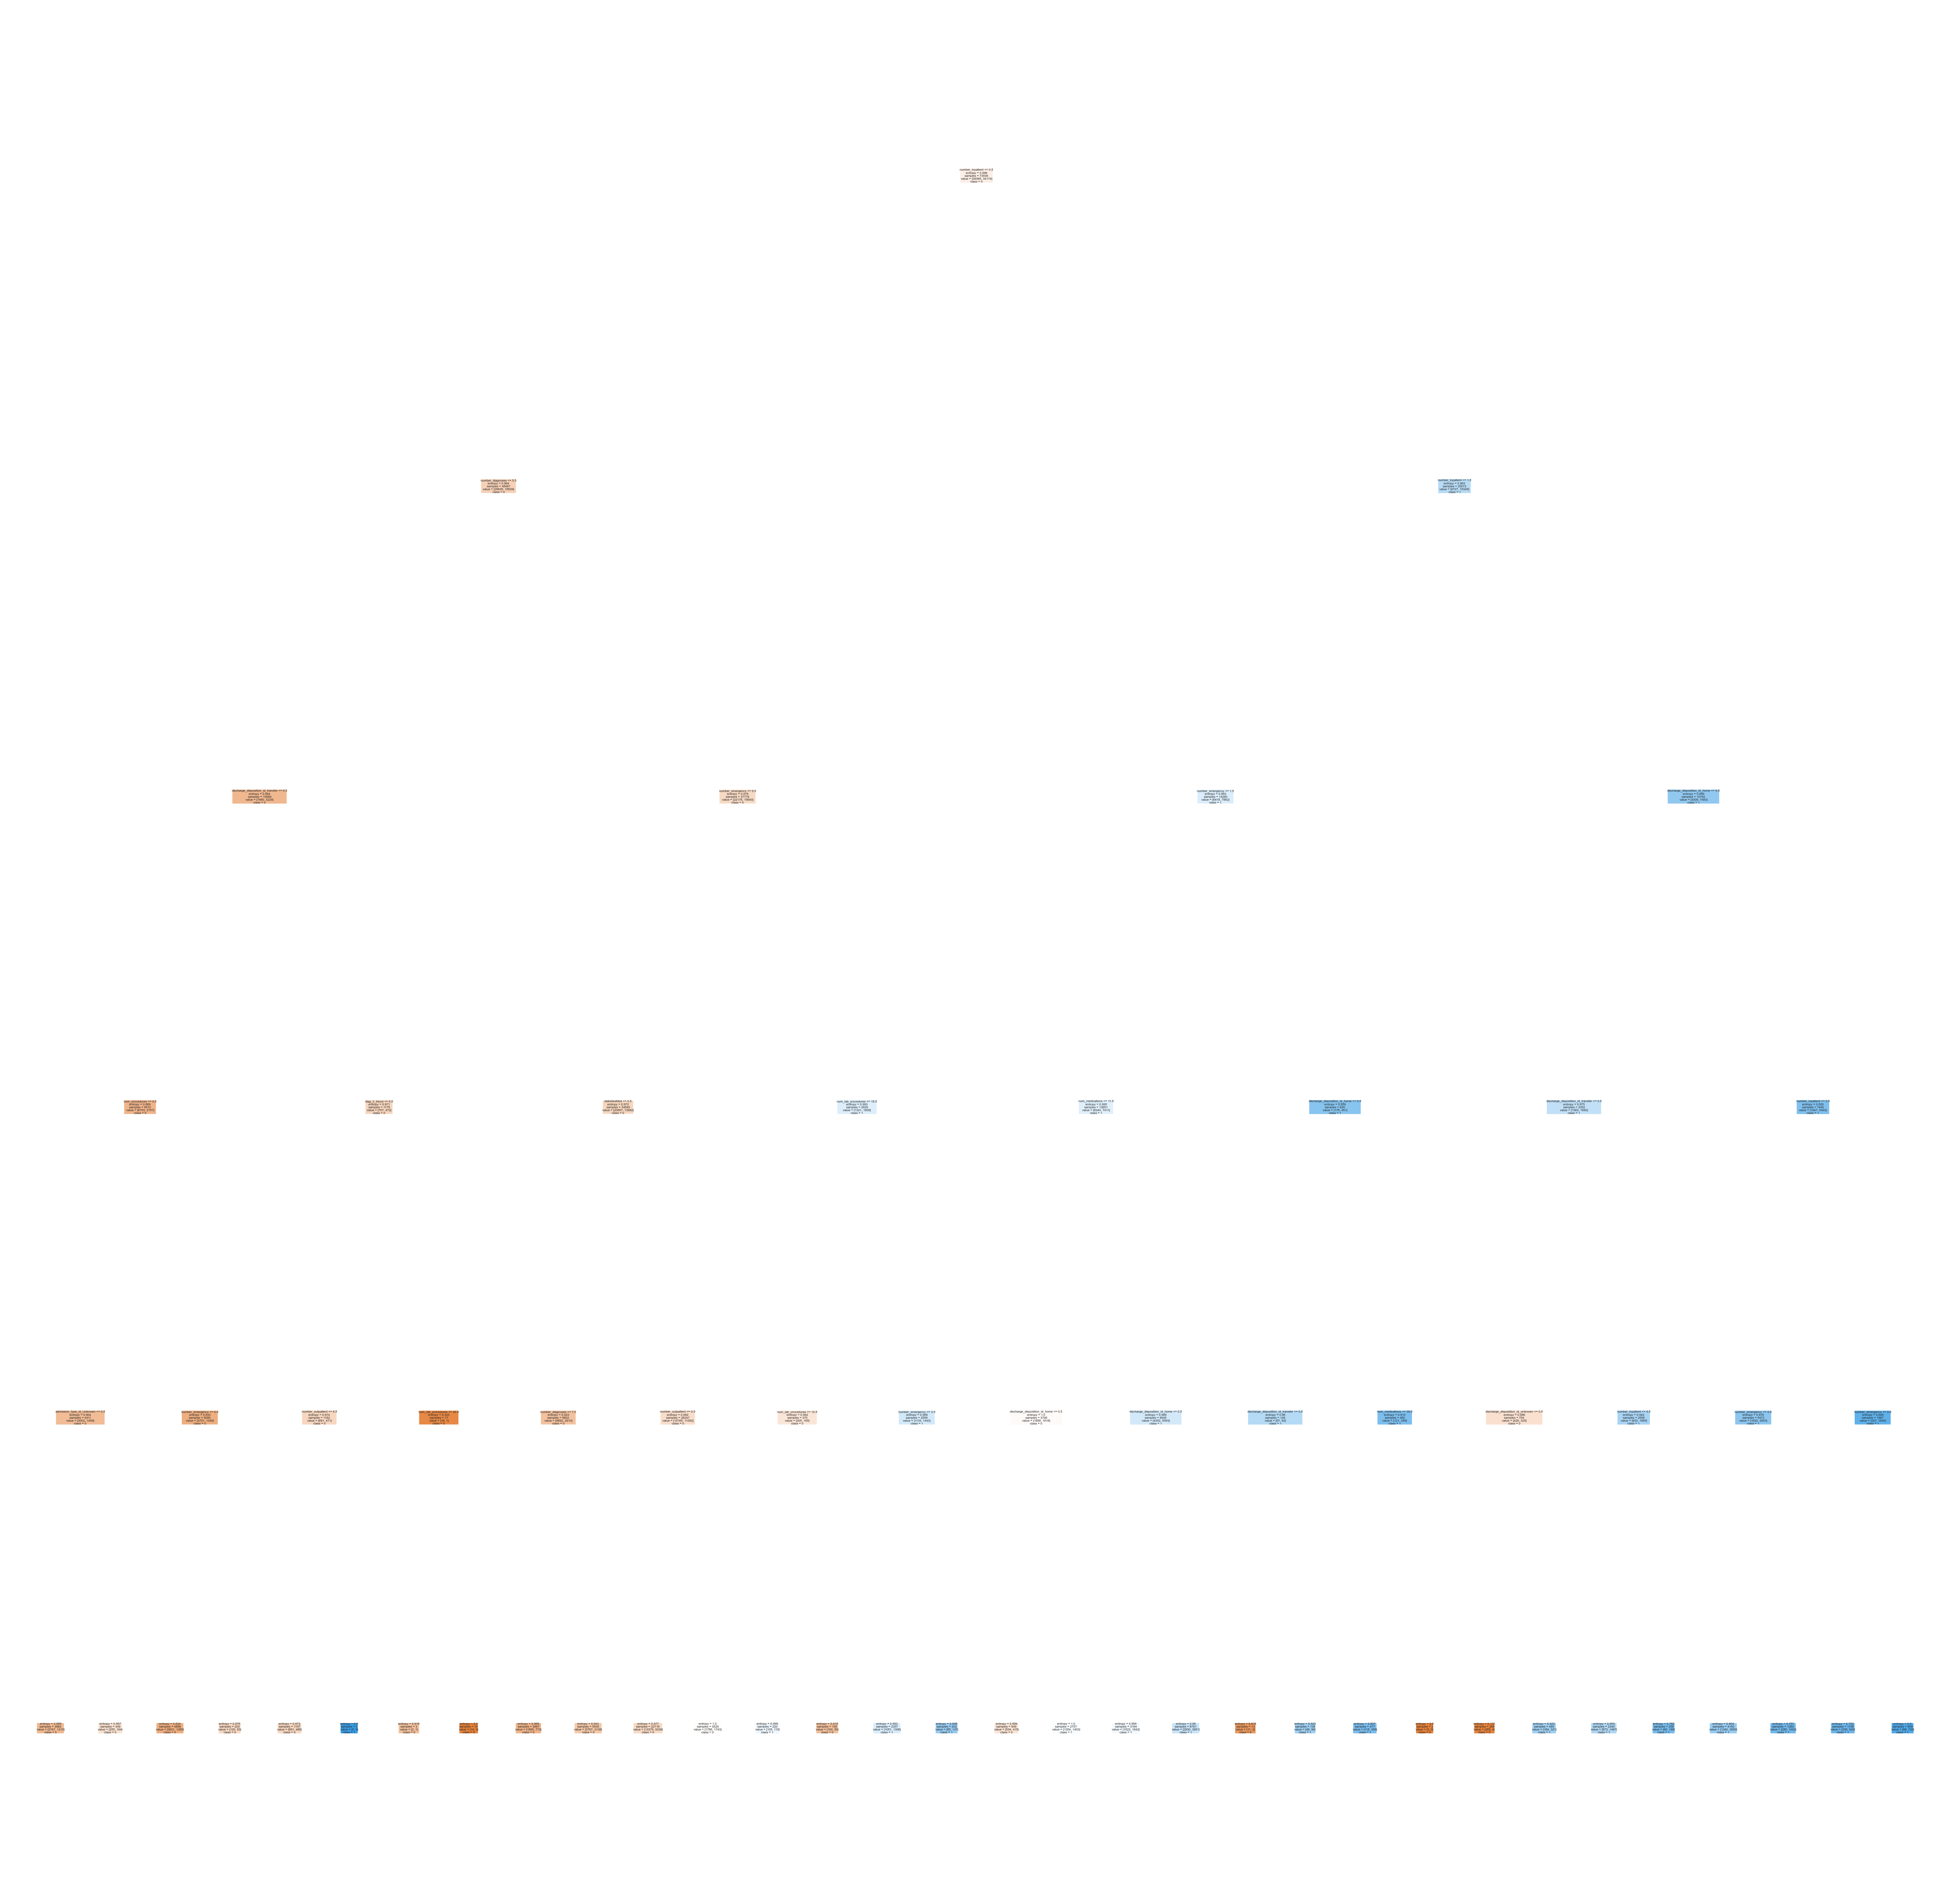

In [190]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (12,12), dpi=500)
plot_tree(new_tree,
            feature_names = X.columns, 
            class_names=np.unique(y).astype('str'),
            filled = True, rounded=True)
plt.show()

Our results did not improve significantly by using a decision tree with optimal parameters over logistic regression. Next, we are going to test out some ensemble methods to try to improve the quality of these predictions.

## Tree Ensemble Methods

In [135]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

### Bagged Tree

The first model we are going to run is a bagged tree model, which is []. We are going to use the same parameters as our grid search tree above and 20 estimators.

              precision    recall  f1-score   support

           0       0.62      0.73      0.67     12972
           1       0.62      0.49      0.55     11541

    accuracy                           0.62     24513
   macro avg       0.62      0.61      0.61     24513
weighted avg       0.62      0.62      0.61     24513



{'precision': 0.62, 'recall': 0.49, 'accuracy': 0.62, 'f1': 0.55}

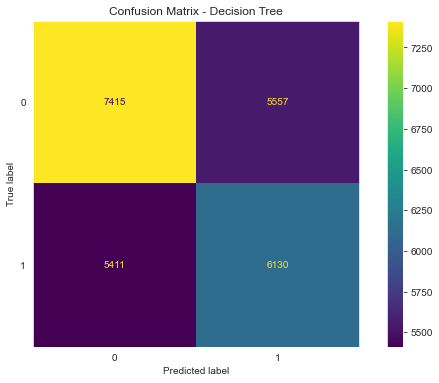

In [192]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion=grid_tree.best_params_['criterion'], 
                                                       max_depth=grid_tree.best_params_['max_depth'], 
                                                       min_samples_split=grid_tree.best_params_['min_samples_split'],
                                                       min_samples_leaf=grid_tree.best_params_['min_samples_leaf']
                                                      ), n_estimators=20)
run_model(bagged_tree)

### Random Forests

Random forests are an ensemble method that create a "forest" of decision trees, which often lead to much better predictions than a single decision tree. We will start with the parameters we found above in our decision tree grid search and use 50 estimators to begin with.

In [143]:
# def run_model(model):
    
#     # fit model
#     model.fit(X_train, y_train)
    
#     # make predictions
#     y_hat_test = model.predict(X_test)
    
#     # print classification report
#     print(classification_report(y_test, y_hat_test))
    
#     # plot confusion matrix
#     fig, ax = plt.subplots(figsize=(10, 6))
#     ax.set_title('Confusion Matrix - Decision Tree')
#     disp = plot_confusion_matrix(dtree_baseline, X_test, y_test, ax = ax)
#     plt.grid(False)
    
    
#     return get_scores(y_test, y_hat_test)

              precision    recall  f1-score   support

           0       0.61      0.78      0.68     12972
           1       0.64      0.43      0.51     11541

    accuracy                           0.62     24513
   macro avg       0.62      0.61      0.60     24513
weighted avg       0.62      0.62      0.60     24513



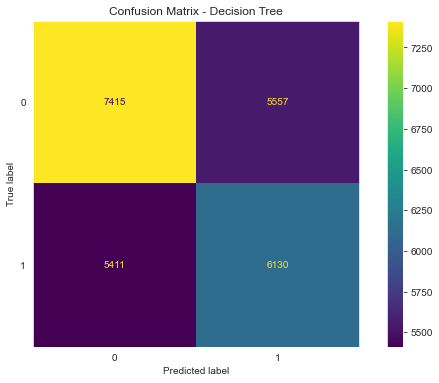

In [193]:
forest = RandomForestClassifier(n_estimators=50, criterion=grid_tree.best_params_['criterion'],
                                max_depth=grid_tree.best_params_['max_depth'],
                                min_samples_split=grid_tree.best_params_['min_samples_split'],
                                min_samples_leaf=grid_tree.best_params_['min_samples_leaf']
                               )
forest_scores = run_model(forest)

                          Feature  Importance
1              num_lab_procedures    0.014570
0                time_in_hospital    0.014754
26  discharge_disposition_id_home    0.015040
2                  num_procedures    0.024051
16                    diabetesMed    0.032245
3                 num_medications    0.065215
4               number_outpatient    0.093170
7                number_diagnoses    0.093581
5                number_emergency    0.150146
6                number_inpatient    0.376479


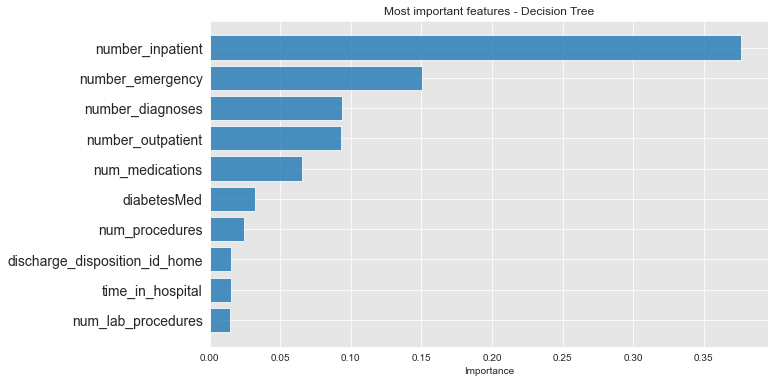

In [194]:
plot_top_10_features(forest)

### Random Forest Improved with Grid Search

Let's see if we can improve these results at all by performing a grid search on the random forest.

In [195]:
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [3,5,10],
    'min_samples_split': [5,10,20],
    'max_features': [5,10,15]
}

In [196]:
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 62.83%

Optimal Parameters: {'max_depth': 10, 'max_features': 15, 'min_samples_split': 10, 'n_estimators': 100}


In [199]:
forest_2 = RandomForestClassifier(n_estimators=100,
                                 max_features=rf_grid_search.best_params_['max_features'], 
                                 max_depth=rf_grid_search.best_params_['max_depth'],
                                 min_samples_split=rf_grid_search.best_params_['min_samples_split'])

              precision    recall  f1-score   support

           0       0.62      0.75      0.68     12972
           1       0.64      0.48      0.55     11541

    accuracy                           0.63     24513
   macro avg       0.63      0.62      0.61     24513
weighted avg       0.63      0.63      0.62     24513



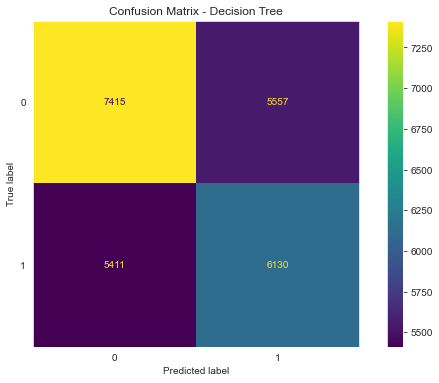

In [200]:
forest_2_scores = run_model(forest_2)

In [197]:
forest_scores

{'precision': 0.64, 'recall': 0.43, 'accuracy': 0.62, 'f1': 0.51}

In [201]:
forest_2_scores

{'precision': 0.64, 'recall': 0.48, 'accuracy': 0.63, 'f1': 0.55}

In [202]:
forest_scores = forest_2_scores

## Boosting Methods

### AdaBoost

In [203]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.62      0.77      0.68     12972
           1       0.64      0.46      0.54     11541

    accuracy                           0.62     24513
   macro avg       0.63      0.62      0.61     24513
weighted avg       0.63      0.62      0.61     24513



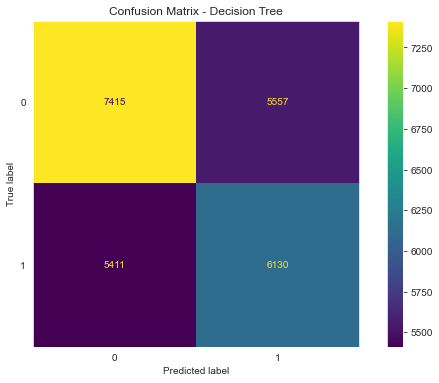

In [204]:
adaboost_clf = AdaBoostClassifier(random_state=42)
ada_scores = run_model(adaboost_clf)

                              Feature  Importance
0                    time_in_hospital        0.02
1                  num_lab_procedures        0.02
2                      num_procedures        0.02
4                   number_outpatient        0.02
3                     num_medications        0.04
5                    number_emergency        0.06
6                    number_inpatient        0.10
29   discharge_disposition_id_unknown        0.10
28  discharge_disposition_id_transfer        0.20
26      discharge_disposition_id_home        0.22


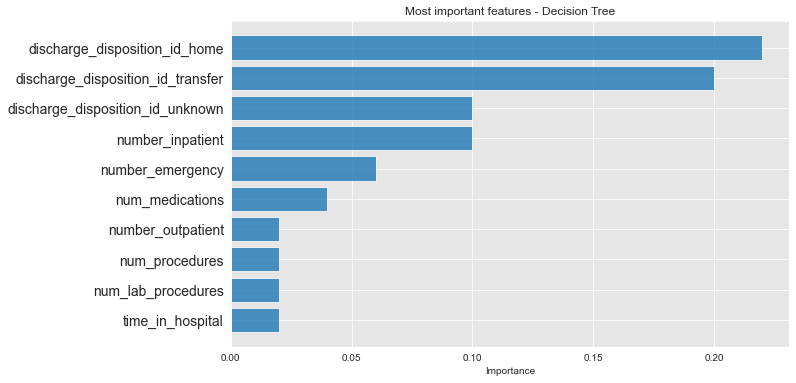

In [205]:
plot_top_10_features(adaboost_clf)

### Gradient Boosting

              precision    recall  f1-score   support

           0       0.62      0.77      0.69     12972
           1       0.65      0.48      0.55     11541

    accuracy                           0.63     24513
   macro avg       0.63      0.62      0.62     24513
weighted avg       0.63      0.63      0.62     24513



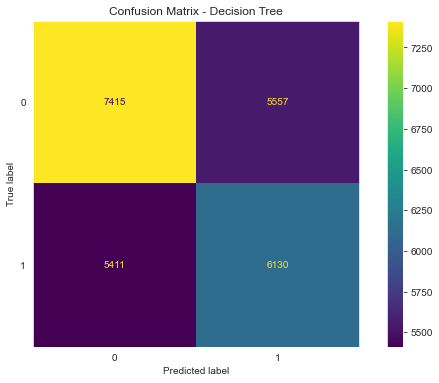

In [206]:
gbt_clf = GradientBoostingClassifier(random_state=42)
gbt_scores = run_model(gbt_clf)

                              Feature  Importance
3                     num_medications    0.023989
1                  num_lab_procedures    0.025180
16                        diabetesMed    0.027397
4                   number_outpatient    0.036036
28  discharge_disposition_id_transfer    0.038052
5                    number_emergency    0.054695
29   discharge_disposition_id_unknown    0.056687
26      discharge_disposition_id_home    0.058156
7                    number_diagnoses    0.065162
6                    number_inpatient    0.494814


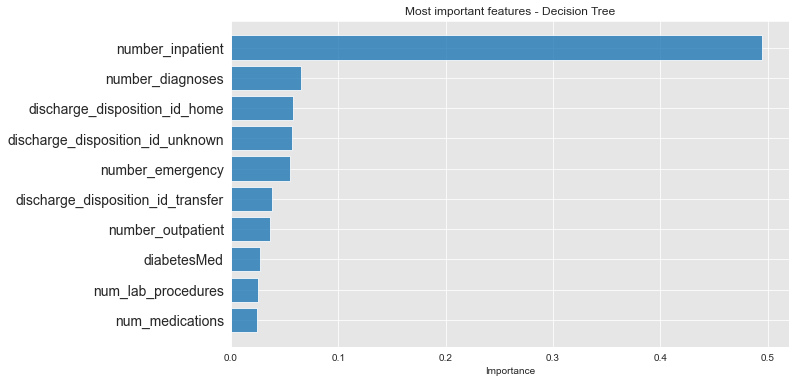

In [207]:
plot_top_10_features(gbt_clf)

### XGBoost

In [208]:
from xgboost import XGBClassifier

In [209]:
X_train.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'metformin', 'repaglinide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'change', 'diabetesMed', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Male',
       'admission_type_id_Emergency', 'admission_type_id_Newborn',
       'admission_type_id_TraumaCenter', 'admission_type_id_Unknown',
       'discharge_disposition_id_home',
       'discharge_disposition_id_not_discharged',
       'discharge_disposition_id_transfer', 'discharge_disposition_id_unknown',
       'diag_1_blood', 'diag_1_circulatory', 'diag_1_digestive',
       'diag_1_endocrine', 'diag_1_genitourinary', 'diag_1_injury',
       'diag_1_mental', 'diag_1_musculoskeletal', 'diag_1_neoplasms',
       'diag_1_nervous', 'diag_1_respiratory', 'diag_2_blood',
       'diag_2_circu

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.63      0.72      0.67     12972
           1       0.63      0.53      0.58     11541

    accuracy                           0.63     24513
   macro avg       0.63      0.63      0.62     24513
weighted avg       0.63      0.63      0.63     24513



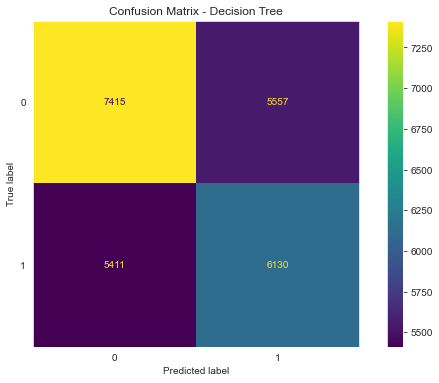

In [210]:
xgb_clf = XGBClassifier()
xgb_scores = run_model(xgb_clf)

                                    Feature  Importance
38                         diag_1_neoplasms    0.016591
27  discharge_disposition_id_not_discharged    0.017364
25                admission_type_id_Unknown    0.018446
7                          number_diagnoses    0.019626
5                          number_emergency    0.023484
26            discharge_disposition_id_home    0.023707
16                              diabetesMed    0.024425
28        discharge_disposition_id_transfer    0.037552
29         discharge_disposition_id_unknown    0.096170
6                          number_inpatient    0.100831


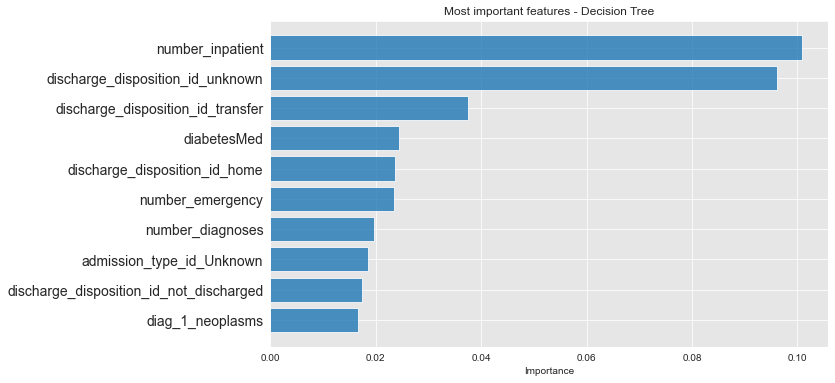

In [211]:
plot_top_10_features(xgb_clf)

In [42]:
# # Instantiate XGBClassifier
# clf = XGBClassifier()

# # Fit XGBClassifier
# clf.fit(X_train, y_train)

# # Predict on training and test sets
# training_preds = clf.predict(X_train)
# test_preds = clf.predict(X_test)

# # Accuracy of training and test sets
# training_accuracy = accuracy_score(y_train, training_preds)
# test_accuracy = accuracy_score(y_test, test_preds)

# print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
# print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:46:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 69.48%
Validation accuracy: 63.11%


### Improve XGBoost Scores Using GridSearch

In [212]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [213]:
xgb_grid_search = GridSearchCV(xgb_clf, xgb_param_grid, scoring='accuracy', cv=None, n_jobs=1)
xgb_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {xgb_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {xgb_grid_search.best_params_}")

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:14:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [215]:
xgb_clf_2 = XGBClassifier(learning_rate = xgb_grid_search.best_params_['learning_rate'],
                          max_depth = xgb_grid_search.best_params_['max_depth'],
                          min_child_weight = xgb_grid_search.best_params_['min_child_weight'],
                          subsample = xgb_grid_search.best_params_['subsample'],
                          n_estimators = xgb_grid_search.best_params_['n_estimators'])

[17:16:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.63      0.74      0.68     12972
           1       0.64      0.51      0.57     11541

    accuracy                           0.64     24513
   macro avg       0.64      0.63      0.63     24513
weighted avg       0.64      0.64      0.63     24513



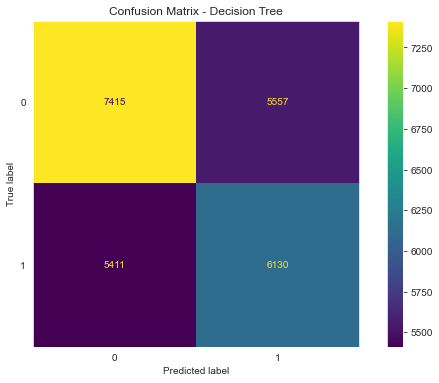

In [216]:
xgb_scores_2 = run_model(xgb_clf_2)

                              Feature  Importance
25          admission_type_id_Unknown    0.016345
4                   number_outpatient    0.016646
38                   diag_1_neoplasms    0.017796
7                    number_diagnoses    0.018822
5                    number_emergency    0.019913
26      discharge_disposition_id_home    0.021433
16                        diabetesMed    0.025326
28  discharge_disposition_id_transfer    0.027589
29   discharge_disposition_id_unknown    0.080149
6                    number_inpatient    0.108175


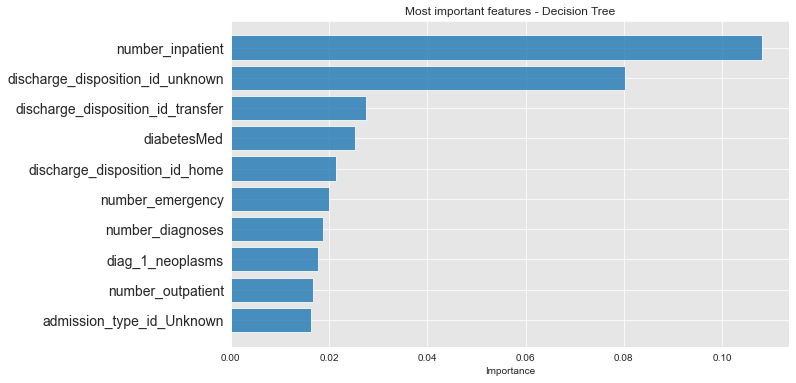

In [217]:
plot_top_10_features(xgb_clf_2)

# Interpretation

## Compare scores of different models

## Interpret Performance of Final Model

## Interpret Results of Final Model